# Deep learning for image Binary classification


In [320]:
import os, shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
from keras import layers
from keras import models
from keras import optimizers
from keras import regularizers
from keras.constraints import maxnorm
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, InceptionV3, ResNet50, VGG19

### Function used to rename the images 

In [321]:
def rename_files(path, new_name, file_extension):
    """
        Perform renaming imges names

        Parameters
        ----------
        path : str 
            path to your images directory
        new_name : str
            new name for an image
        file_extension : str
            extension format
    """
    dirs = os.listdir( path )
    for i,file in enumerate(dirs):
        try:
            os.rename(path + "/" + file, path + "/" + new_name + '.' + str(i) + "file_extension")
            # print (i, file)
        except OSError as err:
            print("OS error: {0}".format(err))
            break

### Path to images data (change it to you own)

In [3]:
# Path to sushi images
original_dataset_dir_sushi = 'path to sushi'

# Path to sandwich images
original_dataset_dir_sandwich = 'path to sandwitch'

# path to the project images
base_dir = 'project path'

### Apply the rename function

In [6]:
rename_files(original_dataset_dir_sushi, 'sushi', '.jpg')
rename_files(original_dataset_dir_sandwich, 'sandwich', '.jpg')

### Create training, validation, and test directories

In [8]:

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
train_sushi_dir = os.path.join(train_dir, 'sushi')
train_sandwich_dir = os.path.join(train_dir, 'sandwich')
validation_sushi_dir = os.path.join(validation_dir, 'sushi')
validation_sandwich_dir = os.path.join(validation_dir, 'sandwich')
test_sushi_dir = os.path.join(test_dir, 'sushi')
test_sandwich_dir = os.path.join(test_dir, 'sandwich')
try:
    os.mkdir(os.path.join('C:/cookpad_classification_project', 'project_dir'))
    os.mkdir(train_dir)
    os.mkdir(validation_dir)
    os.mkdir(test_dir)
    os.mkdir(train_sushi_dir)
    os.mkdir(train_sandwich_dir)
    os.mkdir(validation_sushi_dir)
    os.mkdir(validation_sandwich_dir)
    os.mkdir(test_sushi_dir)
    os.mkdir(test_sandwich_dir)

except OSError as err:
    print("OS error: {0}".format(err))

### Copying images to the directories

In [9]:
fnames = ['sushi.{}.jpg'.format(i) for i in range(302)]
for fname in fnames:
        
    src = os.path.join(original_dataset_dir_sushi, fname)
    dst = os.path.join(train_sushi_dir, fname)
    
    shutil.copyfile(src, dst)
    
fnames = ['sushi.{}.jpg'.format(i) for i in range(302, 352)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_sushi, fname)
    dst = os.path.join(validation_sushi_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['sushi.{}.jpg'.format(i) for i in range(352, 402)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_sushi, fname)
    dst = os.path.join(test_sushi_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['sandwich.{}.jpg'.format(i) for i in range(302)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_sandwich, fname)
    dst = os.path.join(train_sandwich_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['sandwich.{}.jpg'.format(i) for i in range(302, 352)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_sandwich, fname)
    dst = os.path.join(validation_sandwich_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['sandwich.{}.jpg'.format(i) for i in range(352, 402)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_sandwich, fname)
    dst = os.path.join(test_sandwich_dir, fname)
    shutil.copyfile(src, dst)

### Dispaly the number of images at each directory

In [10]:
print('total training sushi images:', len(os.listdir(train_sushi_dir)))
print('total training sandwich images:', len(os.listdir(train_sandwich_dir)))
print('total validation sushi images:', len(os.listdir(validation_sushi_dir)))
print('total validation sandwich images:', len(os.listdir(validation_sandwich_dir)))
print('total test sushi images:', len(os.listdir(test_sushi_dir)))
print('total test sandwich images:', len(os.listdir(test_sandwich_dir)))

total training sushi images: 302
total training sandwich images: 302
total validation sushi images: 50
total validation sandwich images: 50
total test sushi images: 50
total test sandwich images: 50


### Keras model
### Selected model: VGG16 kears with tensorflow backend
### Transfer learning: weights taken from pretrained model on imagenet (top layer not included)

In [11]:
conv_base = VGG16(weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3))

### Model architecture

In [12]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## Training the convnet using data-augmentation generators

In [34]:
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.125,
    height_shift_range=0.125,
    horizontal_flip=True,
    rescale=1./255
)

### Extracting features using the pretrained convolutional base

In [35]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

### Identify batch size 

In [37]:
batch_size = 32

### Extract features

In [38]:
train_features, train_labels = extract_features(train_dir, 604)

Found 604 images belonging to 2 classes.


In [39]:
validation_features, validation_labels = extract_features(validation_dir, 100)

Found 100 images belonging to 2 classes.


### This will be used for the test phase

In [40]:
test_features, test_labels = extract_features(test_dir, 100)

Found 100 images belonging to 2 classes.


### Reshaping the data

In [41]:
train_features = np.reshape(train_features, (604, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (100, 4 * 4 * 512))
test_features = np.reshape(test_features, (100, 4 * 4 * 512))

## Top layer architecture "Densely connected layer"
### Optimizer Adam
### Regularization: Dropout.



In [252]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer= optimizers.adam(lr=.001),
    loss='binary_crossentropy',
    metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=40,
                    batch_size=20,
                    validation_data=(
                        validation_features, validation_labels))

In [253]:
model.compile(optimizer= optimizers.adam(lr=.001),
    loss='binary_crossentropy',
    metrics=['acc'])

In [ ]:
history = model.fit(train_features, train_labels,
                    epochs=40,
                    batch_size=20,
                    validation_data=(
                        validation_features, validation_labels))

# Comments on the validation results
## The model shows some overfitting
### Two mainly solutions (Tune Regularization, or more train data)


## Other solutions
1. Solution suitable with more data in hand but  is so expensive "memory and time": Adding a densely connected classifier on top of the convolutional base.
2. Fine-tuning:consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model "fully connected classifier and these top layers". 



### ========================================================================================

### Plotting the train valdation results

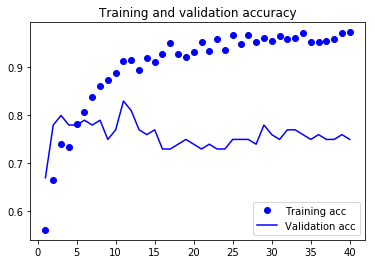

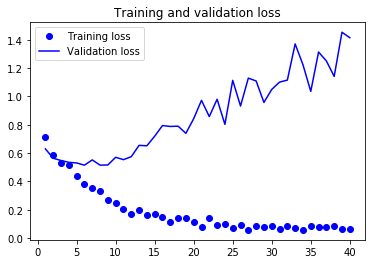

In [256]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Saving the mode

In [319]:
model.save('sushivssandwich.h5')

## Evaluate this model on the test data

In [287]:
pred = model.predict_classes(test_features,batch_size=32)

 32/100 [========>.....................] - ETA: 0s

### Accuracy and roc_auc_scor

In [296]:

print('accuracy = ' + str(sum(pred == test_labels.reshape(-1,1))/len(pred)))
print('roc_auc_score = ' + str(roc_auc_score(pred, test_labels)))

accuracy = [0.82]
roc_auc_score = 0.8205128205128205


## Confusion_matrix

In [293]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [298]:
classes = ['suchi', 'sandwich']

Confusion matrix, without normalization
[[40 10]
 [ 8 42]]


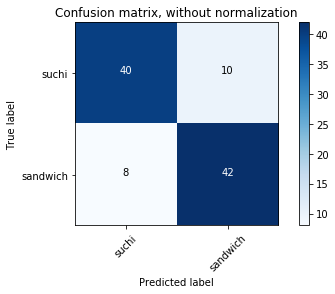

In [305]:
cnf_matrix = confusion_matrix(test_labels, pred)
np.set_printoptions(precision=2)

class_names = classes
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

In [279]:
a = model.predict_classes(test_features,batch_size=32)
roc_auc_score(a, test_labels)

 32/100 [========>.....................] - ETA: 0s

0.8205128205128205

In [310]:
fpr, tpr, thresholds = roc_curve(test_labels, model.predict(test_features))

In [311]:
roc_auc = auc(fpr,tpr)

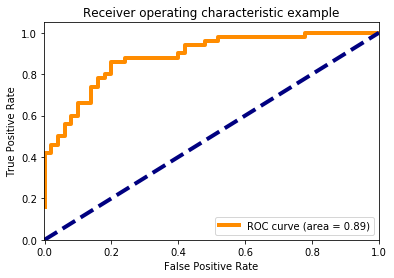

In [318]:
plt.figure()
lw = 3
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()